# Crypto Trading Feature Importance Analysis for Deep Reinforcement Learning

## *~ by Berend Gort, AI4Finance*

Notebook based on:

0: Lopez de Prado, M. (2018). Advances in financial machine learning. John Wiley & Sons.

https://www.amazon.com/Advances-Financial-Machine-Learning-Marcos/dp/1119482089

1: AI4Finance Foundation

https://github.com/AI4Finance-Foundation

2: Optimal Trading Rules Detection with Triple Barrier Labeling

https://www.youtube.com/watch?v=U2CxilKFue4

3: Data Labelling, the Triple-barrier Method

https://towardsdatascience.com/the-triple-barrier-method-251268419dcd


4: Financial Machine Learning Part 1: Labels

https://towardsdatascience.com/financial-machine-learning-part-1-labels-7eeed050f32e#:~:text=Adding%20Path%20Dependency%3A%20Triple%2DBarrier,%3A%20the%20triple%2Dbarrier%20method.


5: Meta-Labeling: Solving for Non Stationarity and Position Sizing

https://www.youtube.com/watch?v=WbgglcXfEzA


6: Advances in Financial Machine Learning

https://github.com/JackBrady/Financial-Machine-Learning/blob/master/USDJPY_Notebook.ipynb


Specifically, important features for currently one coin at the time only

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Meta/blob/master/Demo_Crypto_Feature_Importance.ipynb)




In [ ]:
# Install required packages

%cd /
!git clone https://github.com/AI4Finance-Foundation/FinRL-Meta
%cd /FinRL-Meta/
!pip install git+https://github.com/AI4Finance-LLC/ElegantRL.git
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git
!pip install gputil
!pip install trading_calendars

#install TA-lib (technical analysis)
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz 
!tar xvzf ta-lib-0.4.0-src.tar.gz
import os
os.chdir('ta-lib') 
!./configure --prefix=/usr
!make
!make install
os.chdir('../')
!pip install TA-Lib
!pip install python-binance

/
Cloning into 'FinRL-Meta'...
remote: Enumerating objects: 4979, done.
remote: Counting objects: 100% (1810/1810), done.
remote: Compressing objects: 100% (857/857), done.
remote: Total 4979 (delta 1310), reused 1280 (delta 950), pack-reused 3169
Receiving objects: 100% (4979/4979), 120.09 MiB | 24.56 MiB/s, done.
Resolving deltas: 100% (2630/2630), done.
Checking out files: 100% (397/397), done.
/FinRL-Meta
  Cloning https://github.com/AI4Finance-LLC/ElegantRL.git to /tmp/pip-req-build-q_ikebvu
  Running command git clone -q https://github.com/AI4Finance-LLC/ElegantRL.git /tmp/pip-req-build-q_ikebvu
     |████████████████████████████████| 90.8 MB 1.0 MB/s 
     |████████████████████████████████| 448 kB 46.8 MB/s 
  Created wheel for elegantrl: filename=elegantrl-0.3.3-py3-none-any.whl size=195426 sha256=b4aaa959225b7e41bd6260759a228ad6aed3186e3073a1edaf7556db76f7bd2b
  Stored in directory: /tmp/pip-ephem-wheel-cache-ood6170f/wheels/52/9a/b3/08c8a0b5be22a65da0132538c05e7e961b1253c90d6

     |████████████████████████████████| 108 kB 6.7 MB/s 
  Created wheel for trading-calendars: filename=trading_calendars-2.1.1-py3-none-any.whl size=140935 sha256=30739dd0a9e427b6dd02913bc3d4d60f98bb65aff8496d911cd1455e736d2e87
  Stored in directory: /root/.cache/pip/wheels/62/9c/d1/46a21e1b99e064cba79b85e9f95e6a208ac5ba4c29ae5962ec
Successfully built trading-calendars
--2022-02-25 16:55:16--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-02-25 16:55:16--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)..

In [ ]:
# Other imports

import scipy as sp
import math
import pandas as pd
import requests
import json
import matplotlib.dates as mdates
import numpy as np
import pickle
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns

from datetime import datetime, timedelta
from talib.abstract import MACD, RSI, CCI, DX
from binance.client import Client
from pandas.testing import assert_frame_equal
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import MinMaxScaler 
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from IPython.display import display, HTML

#from google.colab import files

In [ ]:
# Plot settings

SCALE_FACTOR = 2

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [5 * SCALE_FACTOR, 2 * SCALE_FACTOR]
plt.rcParams['figure.dpi'] = 300 * SCALE_FACTOR
plt.rcParams['font.size'] = 5 * SCALE_FACTOR
plt.rcParams['axes.labelsize'] = 5 * SCALE_FACTOR
plt.rcParams['axes.titlesize'] = 6 * SCALE_FACTOR
plt.rcParams['xtick.labelsize'] = 4 * SCALE_FACTOR
plt.rcParams['ytick.labelsize'] = 4 * SCALE_FACTOR
plt.rcParams['font.family'] = 'serif'

In [ ]:
# Set your Binance data API keys!

print('Please enter your main API key:')
API_KEY_Binance = input()

print('Please enter your secret API key:')
API_SECRET_Binance = input()

Please enter your main API key:
qJHiV64YMnIAxA1nQFJOqJf8I9ZHaSfex44EMwLARiWHDGarV9vnvGRJ6na3K6Dp
Please enter your secret API key:
HS3c4TjhLEmMA4U7vGPS6poADyOX32V57jfkqwKOL6cwSz3Ikld6YHxQXQDO51t8


# CH2: Adapted Binance downloader 


Any features you think of are probably coming out of OHLCV data or alternative data streams. The functions required to obtain the new features are added here and added to the eventual dataframe.

In [ ]:
class Binance():
    def __init__(self, api_key_binance, api_secret_binance):
        self.binance_api_key = api_key_binance  # Enter your own API-key here
        self.binance_api_secret = api_secret_binance  # Enter your own API-secret here
        self.binance_client = Client(api_key=api_key_binance, api_secret=api_secret_binance)

    def run(self, ticker_list, start_date, end_date, time_interval, technical_indicator_list, if_vix):
        data = self.download_data(ticker_list, start_date, end_date, time_interval)
        data = self.clean_data(data)
        data = self.add_technical_indicator(data, technical_indicator_list)
        data.index = data['time']

        if if_vix:
            data = self.add_vix(data)

        price_array, tech_array, turbulence_array, time_array = self.df_to_array(data, if_vix)

        tech_nan_positions = np.isnan(tech_array)
        tech_array[tech_nan_positions] = 0

        return data

    # main functions
    def download_data(self, ticker_list, start_date, end_date,
                      time_interval):

        self.start_time = start_date
        self.end_time = end_date
        self.interval = time_interval
        self.ticker_list = ticker_list

        final_df = pd.DataFrame()
        for i in ticker_list:
            hist_data = self.get_binance_bars(self.start_time, self.end_time, self.interval, symbol=i)
            df = hist_data.iloc[:-1]
            df = df.dropna()
            df['tic'] = i
            final_df = final_df.append(df)

        return final_df

    def clean_data(self, df):
        df = df.dropna()

        return df

    def add_technical_indicator(self, df, tech_indicator_list):
        # print('Adding self-defined technical indicators is NOT supported yet.')
        # print('Use default: MACD, RSI, CCI, DX.')
        self.tech_indicator_list = ['open', 'high', 'low', 'close', 'volume',
                                    'macd', 'macd_signal', 'macd_hist',
                                    'rsi', 'cci', 'dx']

        final_df = pd.DataFrame()
        for i in df.tic.unique():
            tic_df = df[df.tic == i].copy()
            tic_df['rsi'] = RSI(tic_df['close'], timeperiod=14)
            tic_df['macd'], tic_df['macd_signal'], tic_df['macd_hist'] = MACD(tic_df['close'], fastperiod=12,
                                                                              slowperiod=26, signalperiod=9)
            tic_df['cci'] = CCI(tic_df['high'], tic_df['low'], tic_df['close'], timeperiod=14)
            tic_df['dx'] = DX(tic_df['high'], tic_df['low'], tic_df['close'], timeperiod=14)
            final_df = final_df.append(tic_df)
        return final_df

    def add_turbulence(self, df):
        print('Turbulence not supported yet. Return original DataFrame.')

        return df

    def add_vix(self, df):
        print('VIX is not applicable for cryptocurrencies. Return original DataFrame')

        return df

    def df_to_array(self, df, if_vix):
        unique_ticker = df.tic.unique()
        if_first_time = True
        for tic in unique_ticker:
            if if_first_time:
                price_array = df[df.tic == tic][['close']].values
                tech_array = df[df.tic == tic][self.tech_indicator_list].values
                if_first_time = False
            else:
                price_array = np.hstack([price_array, df[df.tic == tic][['close']].values])
                tech_array = np.hstack([tech_array, df[df.tic == tic][self.tech_indicator_list].values])

            time_array = df[df.tic == self.ticker_list[0]]['time'].values

        assert price_array.shape[0] == tech_array.shape[0]

        return price_array, tech_array, np.array([]), time_array

    # helper functions
    def stringify_dates(self, date: datetime):
        return str(int(date.timestamp() * 1000))

    def get_binance_bars(self, start_date, end_date, kline_size, symbol):
        data_df = pd.DataFrame()
        klines = self.binance_client.get_historical_klines(symbol, kline_size, start_date, end_date)
        data = pd.DataFrame(klines,
                            columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av',
                                     'trades', 'tb_base_av', 'tb_quote_av', 'ignore'])
        data = data.drop(labels=['close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore'], axis=1)
        if len(data_df) > 0:
            temp_df = pd.DataFrame(data)
            data_df = data_df.append(temp_df)
        else:
            data_df = data

        data_df = data_df.apply(pd.to_numeric, errors='coerce')
        data_df['time'] = [datetime.fromtimestamp(x / 1000.0) for x in data_df.timestamp]
        data.drop(labels=["timestamp"], axis=1)
        data_df.index = [x for x in range(len(data_df))]

        return data_df


## Set contants and use Binance


In [ ]:
# Set constants:

ticker_list = ['BTCUSDT'
              ]


time_interval = '1h'

start_date = '2015-01-01 00:00:00'
end_date = '2020-01-01 00:00:00'


technical_indicator_list = ['open',
                             'high',
                             'low',
                             'close',
                             'volume',
                             'macd',
                             'macd_signal',
                             'macd_hist',
                             'rsi',
                             'cci',
                             'dx'
                             ]

if_vix = False

In [ ]:
# Process data using unified data processor

DP = Binance(API_KEY_Binance, API_SECRET_Binance)
data_ohlcv = DP.run(ticker_list,
              start_date,
              end_date,
              time_interval,
              technical_indicator_list,
              if_vix)

In [ ]:
# Drop unecessary columns

if 'timestamp' in data_ohlcv:
  data_ohlcv.drop('timestamp', inplace=True, axis=1)

if 'time' in data_ohlcv:
  data_ohlcv.drop('time', inplace=True, axis=1)

data_ohlcv.head(3)

,open,high,low,close,volume,tic,rsi,macd,macd_signal,macd_hist,cci,dx
time,,,,,,,,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,BTCUSDT,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,BTCUSDT,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,BTCUSDT,NaN,NaN,NaN,NaN,NaN,NaN


# CH3: Triple barrier method
Introduction here:

https://www.youtube.com/watch?v=U2CxilKFue4

In [ ]:
# IMPORTANT: Make sure that pd.Timedelta() is according to the time_interval to get the volatility for that time interval

if time_interval == '5m':
  Delta = pd.Timedelta(minutes=5)
elif time_interval == '1h':
  Delta = pd.Timedelta(hours=1)
else:
  raise ValueError('Timeframe not supported yet, please manually add!')

In [ ]:
def get_vol(prices, span=100, delta=Delta):

  # 1. compute returns of the form p[t]/p[t-1] - 1
  # 1.1 find the timestamps of p[t-1] values
  df0 = prices.index.searchsorted(prices.index - delta)
  df0 = df0[df0 > 0]

  # 1.2 align timestamps of p[t-1] to timestamps of p[t]
  df0 = pd.Series(prices.index[df0-1],    
           index=prices.index[prices.shape[0]-df0.shape[0] : ])
  
  # 1.3 get values by timestamps, then compute returns
  df0 = prices.loc[df0.index] / prices.loc[df0.values].values - 1

  # 2. estimate rolling standard deviation
  df0 = df0.ewm(span=span).std()
  
  return df0

In [ ]:
data_ohlcv = data_ohlcv.assign(volatility=get_vol(data_ohlcv.close)).dropna()

## Adding Path Dependency: Triple-Barrier Method

To better incorporate the stop-loss and take-profit scenarios of a hypothetical trading strategy, we will modify the fixed-horizon labeling method so that it reflects which barrier has been touched first — upper, lower, or horizon. Hence the name: the triple-barrier method.

The labeling schema is defined as follows:

* y = 2 : top barrier is hit first
* y = 1 : right barrier is hit first
* y = 0 : bottom barrier is hit first

What about the side of the bet?

The schema above works fine for long-only strategies, however things get more complicated when we allow for both long and short bets. If we are betting short, our profit/loss is inverted relative to the price action — we profit if the price goes down and we lose when the price goes up.

In order to account for this, we can simply represent side as 2 for long and 0 for short. Thus we can multiply our returns by the side, so whenever we’re betting short the negative returns become positive and vice-versa. Effectively, we flip the y = 2 and y = 0 labels if side = 0.

Let’s take a shot at the implementation (based on MLDP’s code).
First, we define the procedure for getting the timestamps of the horizon barriers:

## Create function to obtain the barrier hits

In [ ]:
def get_barriers():
  #create a container
  barriers = pd.DataFrame(columns=['days_passed', 
            'price', 'vert_barrier', \
            'top_barrier', 'bottom_barrier'], \
              index = daily_volatility.index)
  for day, vol in daily_volatility.iteritems():


    days_passed = len(daily_volatility.loc \
                  [daily_volatility.index[0] : day])
    #set the vertical barrier 
    if (days_passed + t_final < len(daily_volatility.index) \
        and t_final != 0):
        vert_barrier = daily_volatility.index[
                            days_passed + t_final]
    else:
        vert_barrier = np.nan
    #set the top barrier
    if upper_lower_multipliers[0] > 0:
        top_barrier = prices.loc[day] + prices.loc[day] * \
                      upper_lower_multipliers[0] * vol
    else:
        #set it to NaNs
        top_barrier = pd.Series(index=prices.index)
    #set the bottom barrier
    if upper_lower_multipliers[1] > 0:
        bottom_barrier = prices.loc[day] - prices.loc[day] * \
                      upper_lower_multipliers[1] * vol
    else: 
        #set it to NaNs
        bottom_barrier = pd.Series(index=prices.index)
        
    barriers.loc[day, ['days_passed', 'price', 'vert_barrier','top_barrier', 'bottom_barrier']] = \
    days_passed, prices.loc[day], vert_barrier, top_barrier, bottom_barrier

  return barriers

In [ ]:
# Set barrier parameters

daily_volatility = data_ohlcv['volatility']
t_final = 25
upper_lower_multipliers = [2, 2]
price = data_ohlcv['close']
prices = price[daily_volatility.index]

In [ ]:
barriers = get_barriers()
barriers

,days_passed,price,vert_barrier,top_barrier,bottom_barrier
time,,,,,
2017-08-18 13:00:00,1,4293.09,2017-08-19 15:00:00,4398.683746,4187.496254
2017-08-18 14:00:00,2,4259.4,2017-08-19 16:00:00,4365.829923,4152.970077
2017-08-18 15:00:00,3,4236.89,2017-08-19 17:00:00,4342.632124,4131.147876
2017-08-18 16:00:00,4,4250.34,2017-08-19 18:00:00,4354.277306,4146.402694
2017-08-18 17:00:00,5,4193.35,2017-08-19 19:00:00,4294.927389,4091.772611
...,...,...,...,...,...
2019-12-31 19:00:00,20671,7173.32,NaN,7231.722541,7114.917459
2019-12-31 20:00:00,20672,7176.41,NaN,7234.351644,7118.468356
2019-12-31 21:00:00,20673,7186.19,NaN,7243.829509,7128.550491


## Function to get label for the dataset (0, 1, 2)

* 0: hit the stoploss
* 1: hit the time out
* 2: hit the profit take

The part in this function (commented out), allows for easy conversion to a regression analysis (currently it is classification). If one changes the labels to (-1, 0, 1), and change the hit on the vertical barrier to the function stated below.

That will make hitting the profit take barrier 1, the vertical barrier a range from (-1, 1), and the stoploss barrier -1. This is a continuos space then.

```
barriers['out'][i] = max(
          [(price_final - price_initial)/ 
            (top_barrier - price_initial), \
            (price_final - price_initial)/ \
            (price_initial - bottom_barrier)],\
            key=abs)
```

In [ ]:
def get_labels():
  '''
  start: first day of the window
  end:last day of the window
  price_initial: first day stock price
  price_final:last day stock price
  top_barrier: profit taking limit
  bottom_barrier:stop loss limt
  condition_pt:top_barrier touching conditon
  condition_sl:bottom_barrier touching conditon
  '''

  barriers["label_barrier"] = None
  for i in range(len(barriers.index)):
    start = barriers.index[i]
    end = barriers.vert_barrier[i]
    if pd.notna(end):

        # assign the initial and final price
        price_initial = barriers.price[start]
        price_final = barriers.price[end]

        # assign the top and bottom barriers
        top_barrier = barriers.top_barrier[i]
        bottom_barrier = barriers.bottom_barrier[i]

        #set the profit taking and stop loss conditons
        condition_pt = (barriers.price[start: end] >= \
          top_barrier).any()
        condition_sl = (barriers.price[start: end] <= \
          bottom_barrier).any()

        #assign the labels
        if condition_pt: 
            barriers['label_barrier'][i] = 2
        elif condition_sl: 
            barriers['label_barrier'][i] = 0    
        else: 

          # Change to regression analysis by switching labels (-1, 0, 1)
          # and uncommenting the alternative function for vert barrier

          barriers['label_barrier'][i] = 1
            # barriers['label_barrier'][i] = max(
            #           [(price_final - price_initial)/ 
            #             (top_barrier - price_initial), \
            #             (price_final - price_initial)/ \
            #             (price_initial - bottom_barrier)],\
            #             key=abs)

  return

In [ ]:
# Use function to produce barriers

get_labels()
barriers

# Merge the barriers with the main dataset and drop the last t_final + 1 barriers (as they are too close to the end)

data_ohlcv = data_ohlcv.merge(barriers[['vert_barrier', 'top_barrier', 'bottom_barrier', 'label_barrier']], left_on='time', right_on='time')
data_ohlcv.drop(data_ohlcv.tail(t_final + 1).index,inplace = True)
data_ohlcv.head(5)

,open,high,low,close,volume,tic,rsi,macd,macd_signal,macd_hist,cci,dx,volatility,vert_barrier,top_barrier,bottom_barrier,label_barrier
time,,,,,,,,,,,,,,,,,
2017-08-18 13:00:00,4302.97,4318.16,4221.05,4293.09,46.533767,BTCUSDT,48.125539,-18.499201,-31.273788,12.774587,-37.012578,13.125168,0.012298,2017-08-19 15:00:00,4398.683746,4187.496254,0
2017-08-18 14:00:00,4293.09,4293.09,4193.70,4259.40,74.368943,BTCUSDT,43.983214,-21.199997,-29.259030,8.059032,-106.127710,19.533403,0.012494,2017-08-19 16:00:00,4365.829923,4152.970077,0
2017-08-18 15:00:00,4259.40,4259.40,4200.00,4236.89,39.947717,BTCUSDT,41.418037,-24.870080,-28.381240,3.511160,-163.567590,19.533403,0.012479,2017-08-19 17:00:00,4342.632124,4131.147876,0
2017-08-18 16:00:00,4234.54,4283.79,4234.54,4250.34,45.038824,BTCUSDT,43.537011,-26.389147,-27.982821,1.593674,-87.862104,11.060579,0.012227,2017-08-19 18:00:00,4354.277306,4146.402694,0
2017-08-18 17:00:00,4250.34,4250.34,4066.53,4193.35,62.691466,BTCUSDT,37.369133,-31.824779,-28.751213,-3.073566,-231.476278,41.710866,0.012112,2017-08-19 19:00:00,4294.927389,4091.772611,0


In [ ]:
# Count barrier hits ( -1 = stoploss, 0 = timeout, 1 = profit take)
pd.Series(data_ohlcv['label_barrier']).value_counts()

2    8178
0    6932
1    5539
Name: label_barrier, dtype: int64

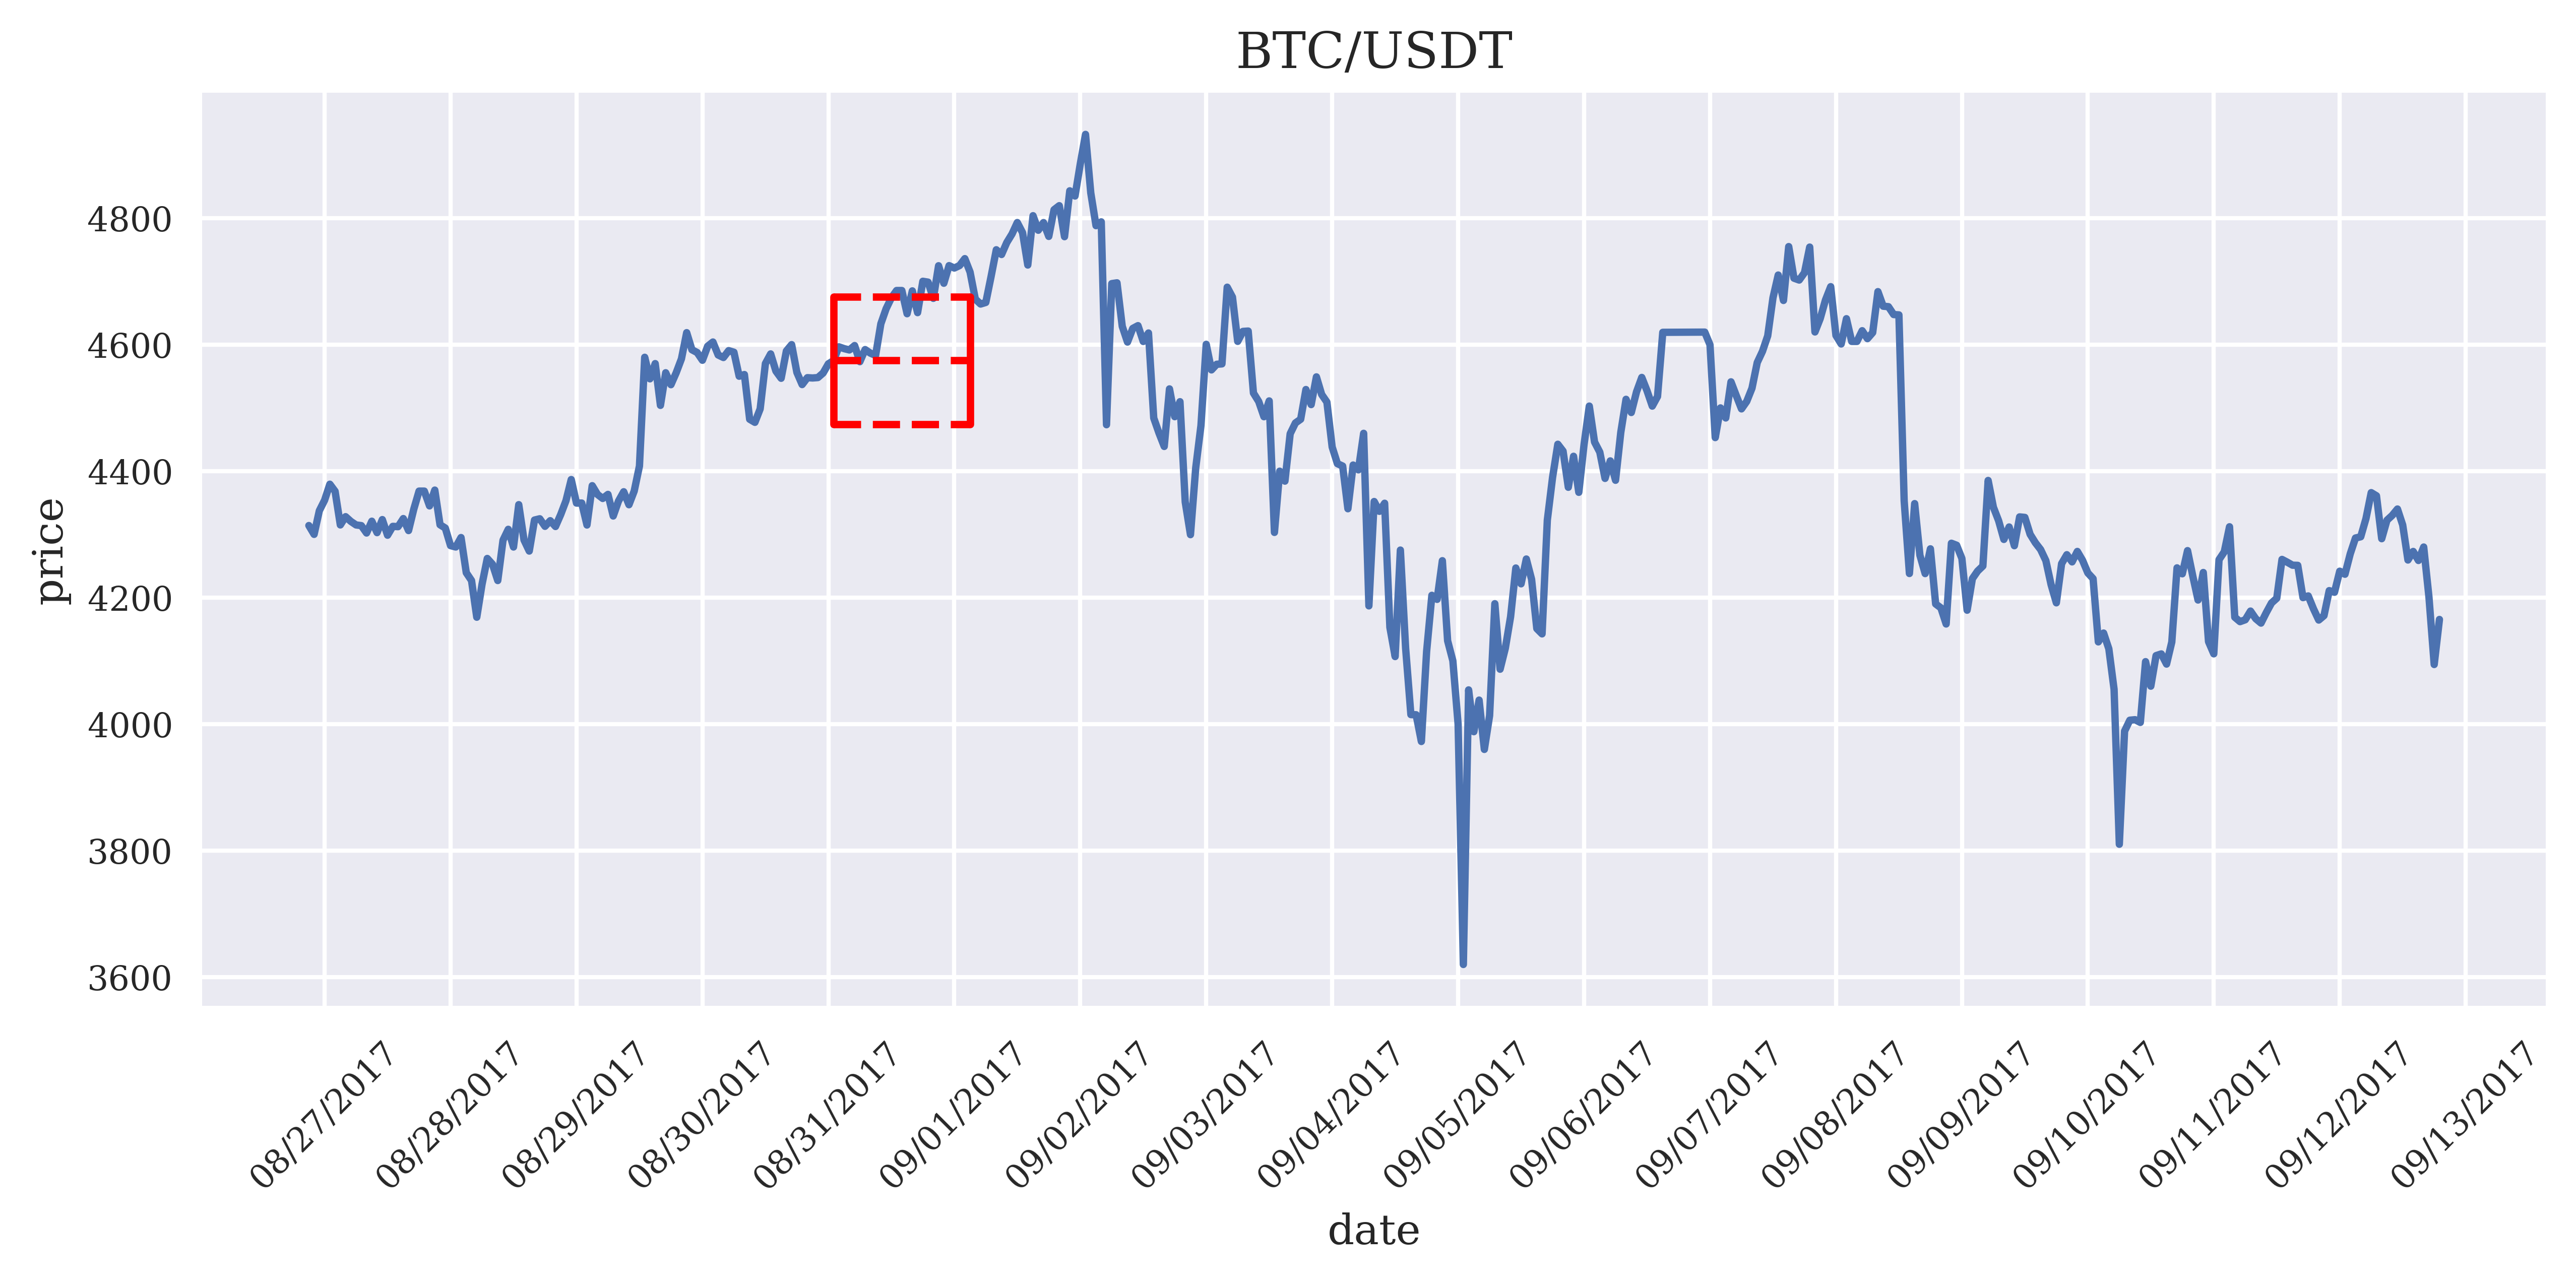

In [ ]:
fig,ax = plt.subplots()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))


TIMESTAMP_TO_PLOT= 300

ax.set(title='BTC/USDT',
       xlabel='date', ylabel='price')
ax.plot(data_ohlcv.close[200:600])

start = data_ohlcv.index[TIMESTAMP_TO_PLOT]
end = data_ohlcv.vert_barrier[TIMESTAMP_TO_PLOT]
upper_barrier = data_ohlcv.top_barrier[TIMESTAMP_TO_PLOT]
lower_barrier = data_ohlcv.bottom_barrier[TIMESTAMP_TO_PLOT]

ax.plot([start, end], [upper_barrier, upper_barrier], 'r--');
ax.plot([start, end], [lower_barrier, lower_barrier], 'r--');
ax.plot([start, end], [(lower_barrier + upper_barrier)*0.5, \
                       (lower_barrier + upper_barrier)*0.5], 'r--');
ax.plot([start, start], [lower_barrier, upper_barrier], 'r-');
ax.plot([end, end], [lower_barrier, upper_barrier], 'r-');

# CH5: Fractional differentation

Standard stationarity transformations, like integer differentiation, further reduce that signal by removing memory. Price series have memory, because every value is dependent upon a long history of previous levels. In contrast, integer differentiated series, like returns, have a memory cut-off, in the sense that history is disregarded entirely after a finite sample window. Once stationarity transformations have wiped out all memory from the data, statisticians resort to complex mathematical techniques to extract what- ever residual signal remains. Not surprisingly, applying these complex techniques on memory-erased series likely leads to false discoveries. In this chapter we introduce a data transformation method that ensures the stationarity of the data while preserving as much memory as possible.

In [ ]:
# Take the required features from the dataset to be differentiated
fractional_diff_data_input = data_ohlcv.drop(['vert_barrier', 'top_barrier', 'bottom_barrier', 'label_barrier','tic'], axis = 1)
fractional_diff_data_input.head(3)

,open,high,low,close,volume,rsi,macd,macd_signal,macd_hist,cci,dx,volatility
time,,,,,,,,,,,,
2017-08-18 13:00:00,4302.97,4318.16,4221.05,4293.09,46.533767,48.125539,-18.499201,-31.273788,12.774587,-37.012578,13.125168,0.012298
2017-08-18 14:00:00,4293.09,4293.09,4193.70,4259.40,74.368943,43.983214,-21.199997,-29.259030,8.059032,-106.127710,19.533403,0.012494
2017-08-18 15:00:00,4259.40,4259.40,4200.00,4236.89,39.947717,41.418037,-24.870080,-28.381240,3.511160,-163.567590,19.533403,0.012479


In [ ]:
def getWeights_FFD(d,thres):
    w,k=[1.],1
    while True:
        w_=-w[-1]/k*(d-k+1)
        if abs(w_)<thres:break
        w.append(w_);k+=1
    return np.array(w[::-1]).reshape(-1,1)

In [ ]:
def fracDiff_FFD(series,d,thres=1e-5):
    # Constant width window (new solution)
    w = getWeights_FFD(d,thres)
    width = len(w)-1
    df={}
    for name in series.columns:
        seriesF, df_=series[[name]].fillna(method='ffill').dropna(), pd.Series()
        for iloc1 in range(width,seriesF.shape[0]):
            loc0,loc1=seriesF.index[iloc1-width], seriesF.index[iloc1]
            test_val = series.loc[loc1,name] # must resample if duplicate index
            if isinstance(test_val, (pd.Series, pd.DataFrame)):
                test_val = test_val.resample('1m').mean()
            if not np.isfinite(test_val).any(): continue # exclude NAs
            try:
                df_.loc[loc1]=np.dot(w.T, seriesF.loc[loc0:loc1])[0,0]
            except:
                continue
        df[name]=df_.copy(deep=True)
    df=pd.concat(df,axis=1)
    return df

In [ ]:
# Requires huge dataset to perform calculation but only is necessary once?!
# Re-do computation for any changes in sampling times!!!

def plotMinFFD(df0, thres=1e-5):
    # pg. 85
    from statsmodels.tsa.stattools import adfuller
    import matplotlib.pyplot as plt

    out=pd.DataFrame(columns=['adfStat','pVal','lags','nObs','95% conf','corr'])
    for d in np.linspace(0,1,11):
        df1=np.log(df0[['close']]).resample('1h').last() # downcast to hourly obs
        df2=fracDiff_FFD(df1,d,thres=thres)
        corr=np.corrcoef(df1.loc[df2.index,'close'],df2['close'])[0,1]

        df2=adfuller(df2['close'],maxlag=1,regression='c',autolag=None)

        out.loc[d]=list(df2[:4])+[df2[4]['5%']]+[corr] # with critical value
    f,ax=plt.subplots(figsize=(9,5))
    out[['adfStat','corr']].plot(ax=ax, secondary_y='adfStat')
    plt.axhline(out['95% conf'].mean(),linewidth=1,color='r',linestyle='dotted')
    return out

In [ ]:
# plotMinFFD(fractional_diff_data_input)

In [ ]:
# Read from the plot above where adfStat crosses the 95% confidence interval and set d accordingly
# That is where the blue line crossed the red dotted line

d = 0.18
fractional_diff_data = fracDiff_FFD(fractional_diff_data_input, d)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys


In [ ]:
# Put the original label back

fractional_diff_data['label_barrier'] = data_ohlcv['label_barrier']
fractional_diff_data.head(3)

,open,high,low,close,volume,rsi,macd,macd_signal,macd_hist,cci,dx,volatility,label_barrier
2018-01-16 03:00:00,2600.089208,2489.291065,2408.293743,2258.426960,149.200261,-2.344110,-117.603647,-27.449833,-90.153814,-81.251002,29.036082,0.003402,0
2018-01-16 04:00:00,2261.569523,2320.787609,2467.116757,2382.191280,-23.163231,0.227406,-133.738465,-48.707560,-85.030906,-62.493453,27.830095,0.003408,0
2018-01-16 05:00:00,2383.556842,2571.469647,2490.378932,2583.721715,-36.981358,5.349013,-128.779118,-64.721871,-64.057247,-28.630778,10.468609,0.003401,0


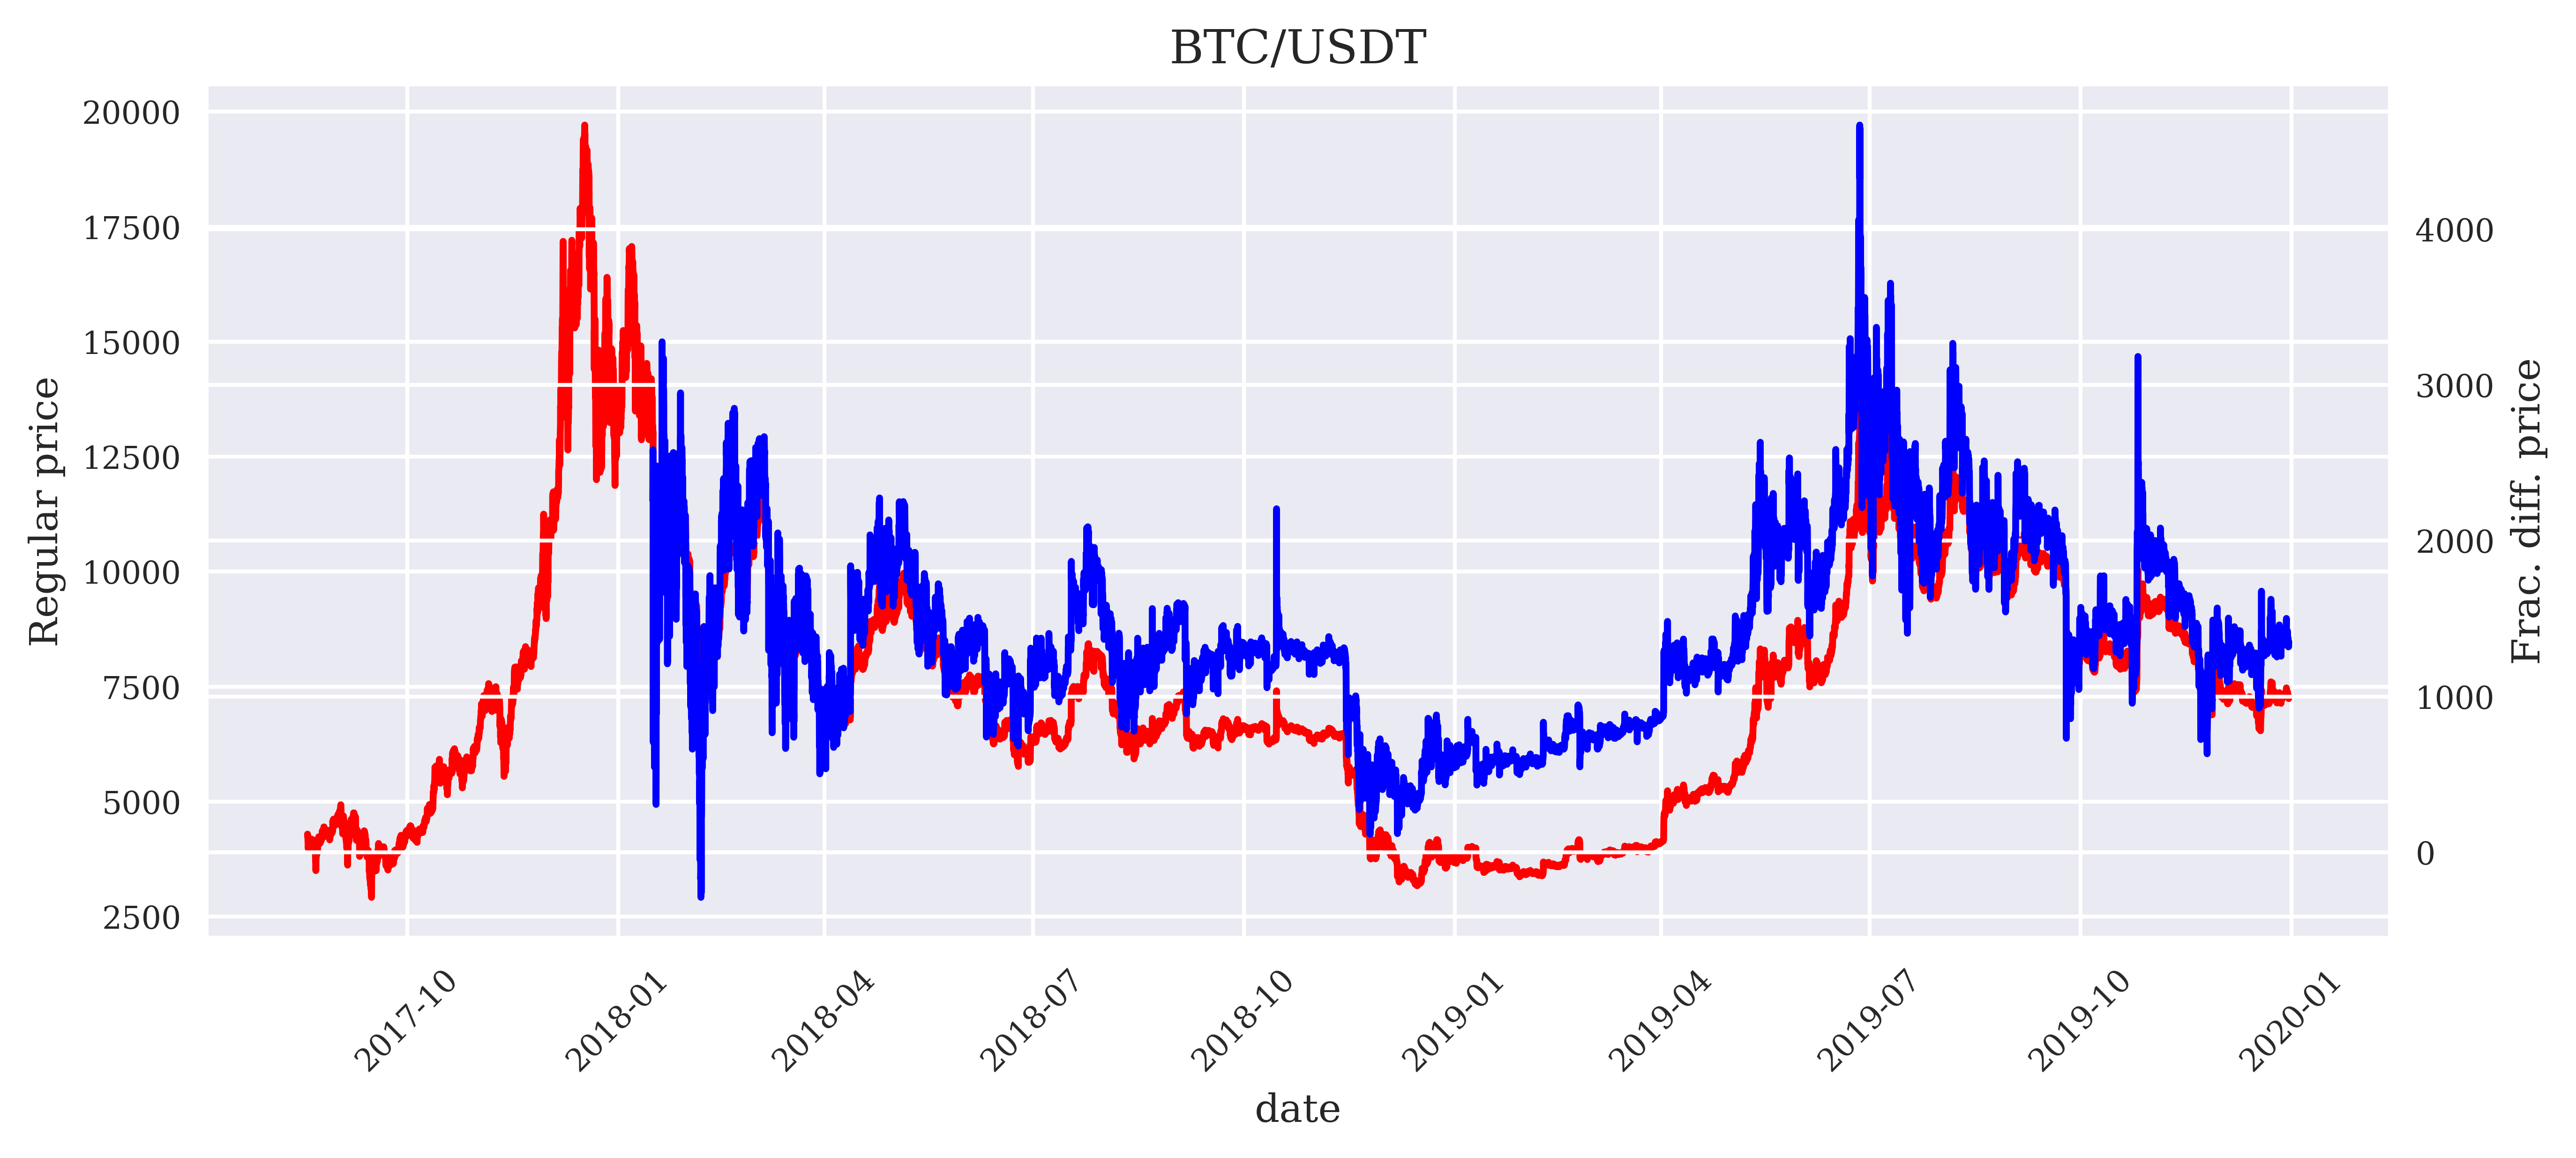

In [ ]:
# Plot the fractionally differentiated data

fig,ax = plt.subplots()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

ax.set(title='BTC/USDT', xlabel='date', ylabel='Regular price')
ax.plot(data_ohlcv.close, color="red")

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
ax2.plot(fractional_diff_data.close, color="blue")
ax2.set_ylabel("Frac. diff. price")
plt.show()

# CH6: Copying the Neural Network present in AI4Finance's ActorPPO agent.

In ElegantRL from AI4Finance, all the preprogrammed Agents are present:

https://github.com/AI4Finance-Foundation/ElegantRL/blob/master/elegantrl/agents/net.py

Some of the actions output discrete actions (classification), and some continuous actions (regression). This notebook can be adapted for both. by turning the labeling method in a (-1, 0, 1) and changing the Neural network to output a continuous space between -1 and 1.

Therefore this notebook allows for analysis for both regression and classification.




In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.state_dim = 12       # all the features
        self.mid_dim = 2**10      # net dimension
        self.action_dim = 3       # output (sell/nothing/buy)

        # make a copy of the model in ActorPPO (activation function in forward function)

        # Original initial layers
        self.fc1 = nn.Linear(self.state_dim, self.mid_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(self.mid_dim, self.mid_dim)

        # Original residual layers
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(self.mid_dim, self.mid_dim)
        self.hw1 = nn.Hardswish()
        self.fc_out = nn.Linear(self.mid_dim, self.action_dim)

    def forward(self, x):
        x = x.float()

        # Original initial layers
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)

        # Original residual layers
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.hw1(x)
        x = self.fc_out(x)
        return x

model_NN1 = Net()
print(model_NN1)

Net(
  (fc1): Linear(in_features=12, out_features=1024, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (hw1): Hardswish()
  (fc_out): Linear(in_features=1024, out_features=3, bias=True)
)


In [ ]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [ ]:
# Set constants
batch_size=16
epochs=300

# Reinitiating data here
data = fractional_diff_data

X = data[['open', 'high', 'low', 'close', 'volume', 'rsi', 'macd', 'macd_signal', 'macd_hist', 'cci', 'dx', 'volatility']].values
y = np.squeeze(data[['label_barrier']].values).astype(int)

# Split into train+val and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# Normalize input
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

# initialize sets and convet them to Pytorch dataloader sets
train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train.astype(int)).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test.astype(int)).long())


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size
                          )

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=1)

In [ ]:
# Check GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Set optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_NN1.parameters(), lr=0.0001)

cuda:0


In [ ]:
## Make sure you are working on GPU
assert torch.cuda.is_available(), "Change your runtime to GPU! Currently working on CPU... zzzzz"

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Feb 25 17:03:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    28W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Now train the ```model_NN1```; as long as the test loss reduces keep on training!

In [ ]:
# Train function
def train(fold, model, device, trainloader, optimizer, epoch):
  model.train()
  correct_train = 0
  correct_this_batch_train = 0
  total_train_loss = 0
  for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = model(data)
      train_loss = criterion(output, target.flatten())
      train_loss.backward()
      optimizer.step()

      if batch_idx % 100 == 0:
          print('Train Fold/Epoch: {}/{} [{}/{} ({:.0f}%)]\ttrain_loss: {:.6f}'.format(
              fold,epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), train_loss.item()))
          
      # Measure accuracy on train set
      total_train_loss += train_loss.item()
      _, y_pred_tags_train = torch.max(output, dim = 1)
      correct_this_batch_train = y_pred_tags_train.eq(target.flatten().view_as(y_pred_tags_train))
      correct_train += correct_this_batch_train.sum().item()
  
  return correct_train, train_loss

In [ ]:
# Test function
def test(fold,model, device, test_loader, correct_train, train_loss):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          test_loss += criterion(output, target.flatten()).item()  # sum up batch loss

          # Measure accuracy on test set
          _, y_pred_tags = torch.max(output, dim = 1)
          correct_this_batch = y_pred_tags.eq(target.flatten().view_as(y_pred_tags))
          correct += correct_this_batch.sum().item()

  test_loss /= len(test_loader.dataset)
  train_loss /= len(train_loader.dataset)

  # Print train accuracy for epoch
  # TODO: still a bug in summed up batch train loss 
  print('\nTrain set for fold {}: Average train_loss: {:.4f}, Accuracy: {}/{} ({:.5f}%)'.format(
  fold, train_loss, correct_train, len(train_loader.dataset),
  100 * correct_train / len(train_loader.dataset)))

  # Print test result for epoch
  print('Test set for fold {}:  Average test_loss:  {:.4f}, Accuracy: {}/{} ({:.5f}%)\n'.format(
      fold, test_loss, correct, len(test_loader.dataset),
      100 * correct / len(test_loader.dataset)))  

In [ ]:
model_NN1.to(device)

# State fold (no PurgedKFold build yet, ignore this)

fold = 0
for epoch in range(1, epochs + 1):
  correct_train, train_loss = train(fold, model_NN1, device, train_loader, optimizer, epoch)
  test(fold, model_NN1, device, test_loader, correct_train, train_loss)

Train Fold/Epoch: 0/1 [0/13634 (0%)]	train_loss: 1.102644
Train Fold/Epoch: 0/1 [1600/13634 (12%)]	train_loss: 1.080605
Train Fold/Epoch: 0/1 [3200/13634 (23%)]	train_loss: 1.133384
Train Fold/Epoch: 0/1 [4800/13634 (35%)]	train_loss: 1.169940
Train Fold/Epoch: 0/1 [6400/13634 (47%)]	train_loss: 1.092049
Train Fold/Epoch: 0/1 [8000/13634 (59%)]	train_loss: 1.035845
Train Fold/Epoch: 0/1 [9600/13634 (70%)]	train_loss: 1.086721
Train Fold/Epoch: 0/1 [11200/13634 (82%)]	train_loss: 1.058849
Train Fold/Epoch: 0/1 [12800/13634 (94%)]	train_loss: 1.032860

Train set for fold 0: Average train_loss: 0.0001, Accuracy: 5190/13634 (38.06660%)
Test set for fold 0:  Average test_loss:  1.0793, Accuracy: 1363/3409 (39.98240%)

Train Fold/Epoch: 0/2 [0/13634 (0%)]	train_loss: 1.064628
Train Fold/Epoch: 0/2 [1600/13634 (12%)]	train_loss: 1.085662
Train Fold/Epoch: 0/2 [3200/13634 (23%)]	train_loss: 1.138574
Train Fold/Epoch: 0/2 [4800/13634 (35%)]	train_loss: 1.172153
Train Fold/Epoch: 0/2 [6400/13634

KeyboardInterrupt: ignored

In [ ]:
# Save model to disk and save in your own files to save you some time

from google.colab import files

filename = 'model_NN1'
out = open(filename, 'wb')

with open(filename + '.pkl', 'wb') as fid:
  pickle.dump(model_NN1, fid)

# load pickle file
with open(filename + '.pkl', 'rb') as fid:
     model_NN1 = pickle.load(fid)

files.download(filename + '.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# load pickle filetorch.from_numpy(y_test.astype(int)).long()

filename = 'model_NN1'
with open(filename + '.pkl', 'rb') as fid:
     model_NN1_pickle = pickle.load(fid)
model_NN1

Net(
  (fc1): Linear(in_features=12, out_features=1024, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (hw1): Hardswish()
  (fc_out): Linear(in_features=1024, out_features=3, bias=True)
)

In [ ]:
with torch.no_grad():
  # Show accuracy on test set
  model_NN1.eval()

  # predict proba
  y_pred_nn1_proba = model_NN1(torch.from_numpy(X_test).float().to(device))
  y_pred_nn1 = torch.argmax(y_pred_nn1_proba, dim=1)
  y_pred_nn1 = y_pred_nn1.cpu().detach().numpy()

# print predction values
print('labels in prediction:', np.unique(y_pred_nn1), '\n')

# print report
label_names = ['long', 'no bet', 'short']
print(classification_report(y_test.astype(int), y_pred_nn1, target_names=label_names))

In [ ]:
np.bincount(y_pred_nn1)

array([ 884,  771, 1754])

# CH8: Feature selection

After we have a working neural network model (up to 66% accuracy with this network size), we can do a pertubation of the columns and do a prediction. When a column is pertubated and it delivers the highest error, that means that column in most important for the prediction of the action.

## Pertubation Rank (PR)

In [ ]:
def perturbation_rank(model,x,y,names):
    errors = []

    X_saved = x
    y = y.flatten()

    with torch.no_grad():
        model.eval()
        for i in range(x.shape[1]):

            # Convert to numpy, shuffle, convert back to tensor, predict
            x = x.detach().numpy()
            np.random.shuffle(x[:,i])
            x = torch.from_numpy(x).float().to(device)
            pred = model(x)

            # log_loss requires (classification target, probabilities)
            pred = pred.cpu().detach().numpy()
            error = metrics.log_loss(y, pred)
            errors.append(error)

            # Reset x to saved tensor matrix
            x = X_saved
    
    max_error = np.max(errors)
    importance = [e/max_error for e in errors]
    
    data = {'name':names,'error':errors,'importance':importance}
    result = pd.DataFrame(data,columns = ['name','error','importance'])
    result.sort_values(by=['importance'],ascending=[0],inplace=True)
    result.reset_index(inplace=True,drop=True)
    return result

In [ ]:
names = list(fractional_diff_data.columns)
names.remove('label_barrier')
rank = perturbation_rank(model_NN1, 
                         torch.from_numpy(X_test).float(),
                         torch.from_numpy(y_test.astype(int)).long(),  
                         names
                         )

display(rank)

,name,error,importance
0,volatility,17.160996,1.000000
1,macd_hist,16.310522,0.950441
2,cci,16.291143,0.949312
3,dx,16.260470,0.947525
4,macd_signal,16.208510,0.944497
5,macd,15.861304,0.924265
6,rsi,15.136324,0.882019
7,volume,15.027760,0.875693
8,close,14.827479,0.864022
9,low,14.760600,0.860125
